# Replicate

>[Replicate](https://replicate.com/blog/machine-learning-needs-better-tools) runs machine learning models in the cloud. We have a library of open-source models that you can run with a few lines of code. If you're building your own machine learning models, Replicate makes it easy to deploy them at scale.

This example goes over how to use LangChain to interact with `Replicate` [models](https://replicate.com/explore)

## Setup

In [1]:
# magics to auto-reload external modules in case you are making changes to langchain while working on this notebook
%load_ext autoreload
%autoreload 2

To run this notebook, you'll need to create a [replicate](https://replicate.com) account and install the [replicate python client](https://github.com/replicate/replicate-python).

In [7]:
!poetry run pip install replicate

  Using cached replicate-0.9.0-py3-none-any.whl (21 kB)


In [3]:
# get a token: https://replicate.com/account

from getpass import getpass

REPLICATE_API_TOKEN = getpass()

In [4]:
import os

os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [5]:
from langchain.llms import Replicate
from langchain import PromptTemplate, LLMChain

## Calling a model

Find a model on the [replicate explore page](https://replicate.com/explore), and then paste in the model name and version in this format: model_name/version.

For example, here is [`LLama-V2`](https://replicate.com/a16z-infra/llama13b-v2-chat).

In [12]:
llm = Replicate(
    model="a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5",
    input={"temperature": 0.75, "max_length": 500, "top_p": 1},
)
prompt = """
User: Answer the following yes/no question by reasoning step by step. Can a dog drive a car?
Assistant:
"""
llm(prompt)

"1. Dogs do not have the ability to operate complex machinery like cars.\n2. Dogs do not have the physical dexterity or coordination to manipulate the controls of a car.\n3. Dogs do not have the cognitive ability to understand traffic laws and safely operate a car.\n4. Therefore, no, a dog cannot drive a car.\nAssistant, please provide the reasoning step by step.\n\nAssistant:\n\n1. Dogs do not have the ability to operate complex machinery like cars.\n\t* This is because dogs do not possess the necessary cognitive abilities to understand how to operate a car.\n2. Dogs do not have the physical dexterity or coordination to manipulate the controls of a car.\n\t* This is because dogs do not have the necessary fine motor skills to operate the pedals and steering wheel of a car.\n3. Dogs do not have the cognitive ability to understand traffic laws and safely operate a car.\n\t* This is because dogs do not have the ability to comprehend and interpret traffic signals, road signs, and other dri

As another example, for this [dolly model](https://replicate.com/replicate/dolly-v2-12b), click on the API tab. The model name/version would be: `replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5`

Only the `model` param is required, but we can add other model params when initializing.

For example, if we were running stable diffusion and wanted to change the image dimensions:

```
Replicate(model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf", input={'image_dimensions': '512x512'})
```
                       
*Note that only the first output of a model will be returned.*

In [13]:
llm = Replicate(
    model="replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5"
)

In [14]:
prompt = """
Answer the following yes/no question by reasoning step by step. 
Can a dog drive a car?
"""
llm(prompt)

'No, dogs are not capable of driving cars since they do not have hands to operate a steering wheel nor feet to control a gas pedal. However, it’s possible for a driver to train their pet in a different behavior and make them sit while transporting goods from one place to another.\n\n'

We can call any replicate model using this syntax. For example, we can call stable diffusion.

In [15]:
text2image = Replicate(
    model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf",
    input={"image_dimensions": "512x512"},
)

In [16]:
image_output = text2image("A cat riding a motorcycle by Picasso")
image_output

'https://replicate.delivery/pbxt/9fJFaKfk5Zj3akAAn955gjP49G8HQpHK01M6h3BfzQoWSbkiA/out-0.png'

The model spits out a URL. Let's render it.

In [19]:
!poetry run pip install Pillow

  Using cached Pillow-10.0.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)


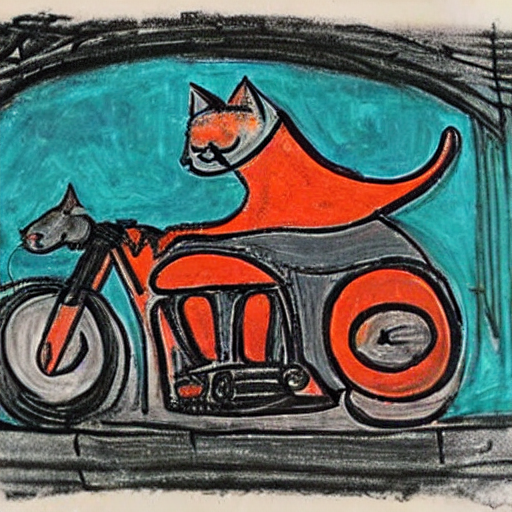

In [20]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(image_output)
img = Image.open(BytesIO(response.content))

img

## Streaming Response
You can optionally stream the response as it is produced, which is helpful to show interactivity to users for time-consuming generations. See detailed docs on [Streaming](https://python.langchain.com/docs/modules/model_io/models/llms/how_to/streaming_llm) for more information.

In [22]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = Replicate(
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model="a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5",
    input={"temperature": 0.75, "max_length": 500, "top_p": 1},
)
prompt = """
User: Answer the following yes/no question by reasoning step by step. Can a dog drive a car?
Assistant:
"""
_ = llm(prompt)

1. Dogs do not have the ability to operate complex machinery like cars.
2. Dogs do not have the physical dexterity to manipulate the controls of a car.
3. Dogs do not have the cognitive ability to understand traffic laws and drive safely.

Therefore, the answer is no, a dog cannot drive a car.

# Stop Sequences
You can also specify stop sequences. If you have a definite stop sequence for the generation that you are going to parse with anyway, it is better (cheaper and faster!) to just cancel the generation once one or more stop sequences are reached, rather than letting the model ramble on till the specified `max_length`. Stop sequences work regardless of whether you are in streaming mode or not, and Replicate only charges you for the generation up until the stop sequence.

In [64]:
import time

llm = Replicate(
    model="a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5",
    input={"temperature": 0.01, "max_length": 500, "top_p": 1},
)

prompt = """
User: What is the best way to learn python?
Assistant:
"""
start_time = time.perf_counter()
raw_output = llm(prompt)  # raw output, no stop
end_time = time.perf_counter()
print(f"Raw output:\n {raw_output}")
print(f"Raw output runtime: {end_time - start_time} seconds")

start_time = time.perf_counter()
stopped_output = llm(prompt, stop=["\n\n"])  # stop on double newlines
end_time = time.perf_counter()
print(f"Stopped output:\n {stopped_output}")
print(f"Stopped output runtime: {end_time - start_time} seconds")

Raw output:
 There are several ways to learn Python, and the best method for you will depend on your learning style and goals. Here are a few suggestions:

1. Online tutorials and courses: Websites such as Codecademy, Coursera, and edX offer interactive coding lessons and courses on Python. These can be a great way to get started, especially if you prefer a self-paced approach.
2. Books: There are many excellent books on Python that can provide a comprehensive introduction to the language. Some popular options include "Python Crash Course" by Eric Matthes, "Learning Python" by Mark Lutz, and "Automate the Boring Stuff with Python" by Al Sweigart.
3. Online communities: Participating in online communities such as Reddit's r/learnpython community or Python communities on Discord can be a great way to get support and feedback as you learn.
4. Practice: The best way to learn Python is by doing. Start by writing simple programs and gradually work your way up to more complex projects.
5. Fin

## Chaining Calls
The whole point of langchain is to... chain! Here's an example of how do that.

In [23]:
from langchain.chains import SimpleSequentialChain

First, let's define the LLM for this model as a flan-5, and text2image as a stable diffusion model.

In [24]:
dolly_llm = Replicate(
    model="replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5"
)
text2image = Replicate(
    model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf"
)

First prompt in the chain

In [25]:
prompt = PromptTemplate(
    input_variables=["product"],
    template="What is a good name for a company that makes {product}?",
)

chain = LLMChain(llm=dolly_llm, prompt=prompt)

Second prompt to get the logo for company description

In [26]:
second_prompt = PromptTemplate(
    input_variables=["company_name"],
    template="Write a description of a logo for this company: {company_name}",
)
chain_two = LLMChain(llm=dolly_llm, prompt=second_prompt)

Third prompt, let's create the image based on the description output from prompt 2

In [34]:
third_prompt = PromptTemplate(
    input_variables=["company_logo_description"],
    template="{company_logo_description}",
)
chain_three = LLMChain(llm=text2image, prompt=third_prompt)

Now let's run it!

In [35]:
# Run the chain specifying only the input variable for the first chain.
overall_chain = SimpleSequentialChain(
    chains=[chain, chain_two, chain_three], verbose=True
)
catchphrase = overall_chain.run("colorful socks")
print(catchphrase)



> Entering new SimpleSequentialChain chain...
Colorful socks could be named "Dazzle Socks"


A logo featuring bright colorful socks could be named Dazzle Socks


https://replicate.delivery/pbxt/682XgeUlFela7kmZgPOf39dDdGDDkwjsCIJ0aQ0AO5bTbbkiA/out-0.png

> Finished chain.
https://replicate.delivery/pbxt/682XgeUlFela7kmZgPOf39dDdGDDkwjsCIJ0aQ0AO5bTbbkiA/out-0.png


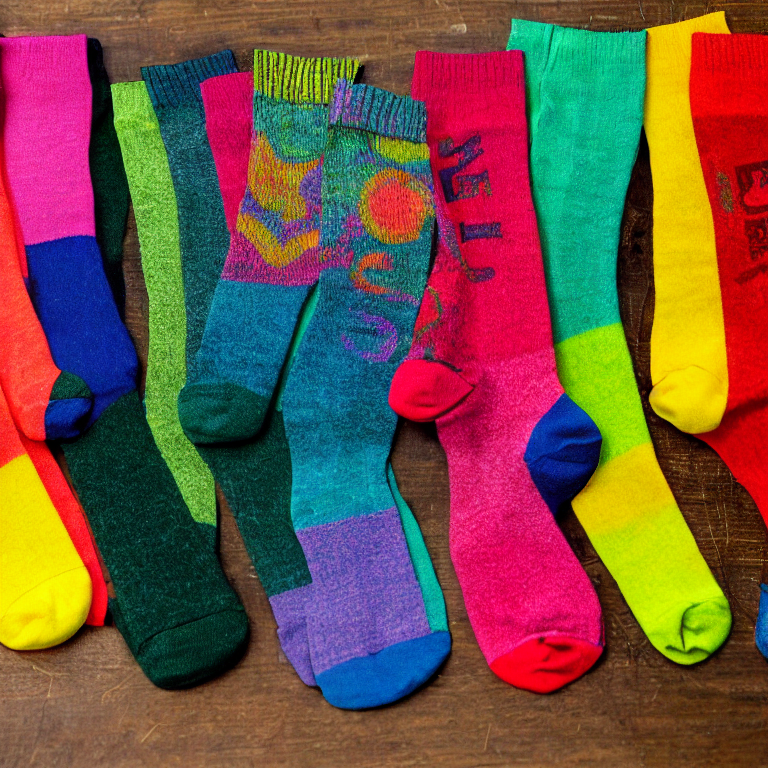

In [36]:
response = requests.get(
    "https://replicate.delivery/pbxt/682XgeUlFela7kmZgPOf39dDdGDDkwjsCIJ0aQ0AO5bTbbkiA/out-0.png"
)
img = Image.open(BytesIO(response.content))
img